--------------
**Validation of Bitcoin Addresses and Illicit Class Status**

The purpose of this notebook is to validate illicit accounts using external sources. Before any analysis is undertaken, the Bitcoin transaction and wallet data needs to be validated in order to be able to reply on the dataset.

The dataset contains 823k unique addresses with illicit, licit and unknown status. This notebook validates 15 illicit addresses and the corresponding transaction using a third party source.

The Elliptic++ dataset is an enhancement of the Elliptic1 dataset. This dataset includes transaction information that can be validated using blockchain wallet search websites. See here:

Elliptic1 Paper and Dataset:
https://arxiv.org/pdf/1908.02591
https://www.kaggle.com/datasets/ellipticco/elliptic-data-set/data

Elliptic++ Paper and Dataset:
https://arxiv.org/pdf/2306.06108
https://github.com/git-disl/EllipticPlusPlus

--------------

In [ ]:
# Data cleaning and manipulation
import pandas as pd
import numpy as np
from pandas_gbq import to_gbq

# Set up display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)


-------------------

Read in Datasets used for Validation

-------------------

Dataset 1: Aggregate 'wallets_combined_clean' dataset which contains aggregate transaction information at an address level and contains the class (illicit, licit or unknown).

Dataset 2: The 'addraddr_edgelist' which contains a directional address to address (sending address to receiving address) which will be used to validate the addresses involved in the transaction.

Dataset 3: The 'addrtxn_edgelist' will be used to look up the masked transaction ID to find the transaction features in 'txn_features' table.

Dataset 4: The 'txn_features' dataset contains both masked and unmasked transaction features that will be used to validate the 30 samples.

In [ ]:
# Read in combined wallet features table from BigQuery
%%bigquery df_wallet_combined_clean
select * from `sixth-legend-440110-g7.actor_data.wallets_combined_clean`;

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
print(df_wallet_combined_clean.shape)
df_wallet_combined_clean.head(1)

(822942, 58)


,address,class,class_label,num_txs_as_sender,num_txs_as receiver,first_block_appeared_in,last_block_appeared_in,lifetime_in_blocks,total_txs,first_sent_block,first_received_block,num_timesteps_appeared_in,btc_transacted_total,btc_transacted_min,btc_transacted_max,btc_transacted_mean,btc_transacted_median,btc_sent_total,btc_sent_min,btc_sent_max,btc_sent_mean,btc_sent_median,btc_received_total,btc_received_min,btc_received_max,btc_received_mean,btc_received_median,fees_total,fees_min,fees_max,fees_mean,fees_median,fees_as_share_total,fees_as_share_min,fees_as_share_max,fees_as_share_mean,fees_as_share_median,blocks_btwn_txs_total,blocks_btwn_txs_min,blocks_btwn_txs_max,blocks_btwn_txs_mean,blocks_btwn_txs_median,blocks_btwn_input_txs_total,blocks_btwn_input_txs_min,blocks_btwn_input_txs_max,blocks_btwn_input_txs_mean,blocks_btwn_input_txs_median,blocks_btwn_output_txs_total,blocks_btwn_output_txs_min,blocks_btwn_output_txs_max,blocks_btwn_output_txs_mean,blocks_btwn_output_txs_median,num_addr_transacted_multiple,transacted_w_address_total,transacted_w_address_min,transacted_w_address_max,transacted_w_address_mean,transacted_w_address_median
0,12m825yQ4vhS2zrd7ynZT4bBqKSMZYxuku,3,Unknown,1.0000,0.0000,457729.0000,457729.0000,0.0000,1.0000,457729.0000,0.0000,1.0000,0.0427,0.0427,0.0427,0.0427,0.0427,0.0427,0.0427,0.0427,0.0427,0.0427,0.0000,0.0000,0.0000,0.0000,0.0000,0.0028,0.0028,0.0028,0.0028,0.0028,0.0003,0.0003,0.0003,0.0003,0.0003,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,1.0000,1.0000,1.0000,1.0000


In [ ]:
# Read in address to address table from BigQuery
%%bigquery df_addraddr
select * from `sixth-legend-440110-g7.actor_data.addraddr_edgelist`;

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
print(df_addraddr.shape)
df_addraddr.head(1)

(2868964, 2)


,input_address,output_address
0,1MAQQZn7EHP6J3erXByCciFiVcgS8ZhWqz,19q57SeCEzTnWrWVXA43nZzhSiXkYggh7c


In [ ]:
# Read in address to transaction table from BigQuery
%%bigquery df_addrtxn_edgelist
select * from `sixth-legend-440110-g7.actor_data.addrtxn_edgelist`;

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
print(df_addrtxn_edgelist.shape)
df_addrtxn_edgelist.head(1)

(477117, 2)


,input_address,txId
0,14YRXHHof4BY1TVxN5FqYPcEdpmXiYT78a,230325127


In [ ]:
# Read in address to address table from BigQuery
%%bigquery df_txn_features
select * from `sixth-legend-440110-g7.txn_data.txn_features`;

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
# subset txn feature to remove all masked aggregate and local features

# Remove columns containing 'Aggregate_feature_' or 'Local_feature_'
columns_to_remove = [col for col in df_txn_features.columns if 'Aggregate_feature_' in col or 'Local_feature_' in col]
df_txn_features = df_txn_features.drop(columns=columns_to_remove)

In [ ]:
print(df_txn_features.shape)
df_txn_features.head(1)

(203769, 19)


,txId,Time step,in_txs_degree,out_txs_degree,total_BTC,fees,size,num_input_addresses,num_output_addresses,in_BTC_min,in_BTC_max,in_BTC_mean,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total
0,386141483,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


----------------------

Illicit Samples where the volume of transactions is low.

The reason for selecting addresses with low transaction values is so we can validate the transactions using third party Blockchain websites.

----------------------

In [ ]:
illicit_samples = df_wallet_combined_clean[(df_wallet_combined_clean['class_label']=='Illicit') & (df_wallet_combined_clean['num_txs_as_sender']==1) & (df_wallet_combined_clean['total_txs']==1)].sort_values(ascending = True, by = 'total_txs').head(10)
illicit_samples

,address,class,class_label,num_txs_as_sender,num_txs_as receiver,first_block_appeared_in,last_block_appeared_in,lifetime_in_blocks,total_txs,first_sent_block,first_received_block,num_timesteps_appeared_in,btc_transacted_total,btc_transacted_min,btc_transacted_max,btc_transacted_mean,btc_transacted_median,btc_sent_total,btc_sent_min,btc_sent_max,btc_sent_mean,btc_sent_median,btc_received_total,btc_received_min,btc_received_max,btc_received_mean,btc_received_median,fees_total,fees_min,fees_max,fees_mean,fees_median,fees_as_share_total,fees_as_share_min,fees_as_share_max,fees_as_share_mean,fees_as_share_median,blocks_btwn_txs_total,blocks_btwn_txs_min,blocks_btwn_txs_max,blocks_btwn_txs_mean,blocks_btwn_txs_median,blocks_btwn_input_txs_total,blocks_btwn_input_txs_min,blocks_btwn_input_txs_max,blocks_btwn_input_txs_mean,blocks_btwn_input_txs_median,blocks_btwn_output_txs_total,blocks_btwn_output_txs_min,blocks_btwn_output_txs_max,blocks_btwn_output_txs_mean,blocks_btwn_output_txs_median,num_addr_transacted_multiple,transacted_w_address_total,transacted_w_address_min,transacted_w_address_max,transacted_w_address_mean,transacted_w_address_median
62,1H6iGtpj4AH9C6xKgKWPtoJF4miRoGziin,1,Illicit,1.0000,0.0000,445634.0000,445634.0000,0.0000,1.0000,445634.0000,0.0000,1.0000,0.0211,0.0211,0.0211,0.0211,0.0211,0.0211,0.0211,0.0211,0.0211,0.0211,0.0000,0.0000,0.0000,0.0000,0.0000,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
120785,1DzPbE2QET1WmdiFywGyxzSNWWBC7jAuSz,1,Illicit,1.0000,0.0000,459750.0000,459750.0000,0.0000,1.0000,459750.0000,0.0000,1.0000,0.0020,0.0020,0.0020,0.0020,0.0020,0.0020,0.0020,0.0020,0.0020,0.0020,0.0000,0.0000,0.0000,0.0000,0.0000,0.0388,0.0388,0.0388,0.0388,0.0388,0.0001,0.0001,0.0001,0.0001,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
120851,1EsMBSwcw94uCmph4bTshs6o8THZQn3QFZ,1,Illicit,1.0000,0.0000,435554.0000,435554.0000,0.0000,1.0000,435554.0000,0.0000,1.0000,0.0046,0.0046,0.0046,0.0046,0.0046,0.0046,0.0046,0.0046,0.0046,0.0046,0.0000,0.0000,0.0000,0.0000,0.0000,0.0005,0.0005,0.0005,0.0005,0.0005,0.0001,0.0001,0.0001,0.0001,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,1.0000,1.0000,1.0000,1.0000
120870,1CXu6V1gdEqQcd3A6E1aLDqrdzJUSZTVwK,1,Illicit,1.0000,0.0000,483943.0000,483943.0000,0.0000,1.0000,483943.0000,0.0000,1.0000,3.4897,3.4897,3.4897,3.4897,3.4897,3.4897,3.4897,3.4897,3.4897,3.4897,0.0000,0.0000,0.0000,0.0000,0.0000,0.0076,0.0076,0.0076,0.0076,0.0076,0.0005,0.0005,0.0005,0.0005,0.0005,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,1.0000,1.0000,1.0000,1.0000
120902,1H2oqGARVmLUE76reV4ZdPnaVR1MHTyc6V,1,Illicit,1.0000,0.0000,475872.0000,475872.0000,0.0000,1.0000,475872.0000,0.0000,1.0000,0.0594,0.0594,0.0594,0.0594,0.0594,0.0594,0.0594,0.0594,0.0594,0.0594,0.0000,0.0000,0.0000,0.0000,0.0000,0.0012,0.0012,0.0012,0.0012,0.0012,0.0001,0.0001,0.0001,0.0001,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,1.0000,1.0000,1.0000,1.0000
120943,1D1SLGb19PASxR3dCY7qXLVFnsDsnJu4GL,1,Illicit,1.0000,0.0000,485958.0000,485958.0000,0.0000,1.0000,485958.0000,0.0000,1.0000,0.0091,0.0091,0.0091,0.0091,0.0091,0.0091,0.0091,0.0091,0.0091,0.0091,0.0000,0.0000,0.0000,0.0000,0.0000,0.0019,0.0019,0.0019,0.0019,0.0019,0.0001,0.0001,0.0001,0.0001,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,1.0000,1.0000,1.0000,1.0000
120967,1BmwhwBzyeuNoZirB6hmeDEqztUZTyJ8qC,1,Illicit,1.0000,0.0000,445634.0000,445634.0000,0.0000,1.0000,445634.0000,0.0000,1.0000,0.07

-----------------------

Illicit Address Validation #1: 1H6iGtpj4AH9C6xKgKWPtoJF4miRoGziin

Notes:
- Input address, output address and BTC txn value are validated using BTC Scan https://btcscan.org/address/1H6iGtpj4AH9C6xKgKWPtoJF4miRoGziin
- No illicit reports on https://www.chainabuse.com/
- No illicit reports on https://tools.cybertrace.com.au/

-----------------------

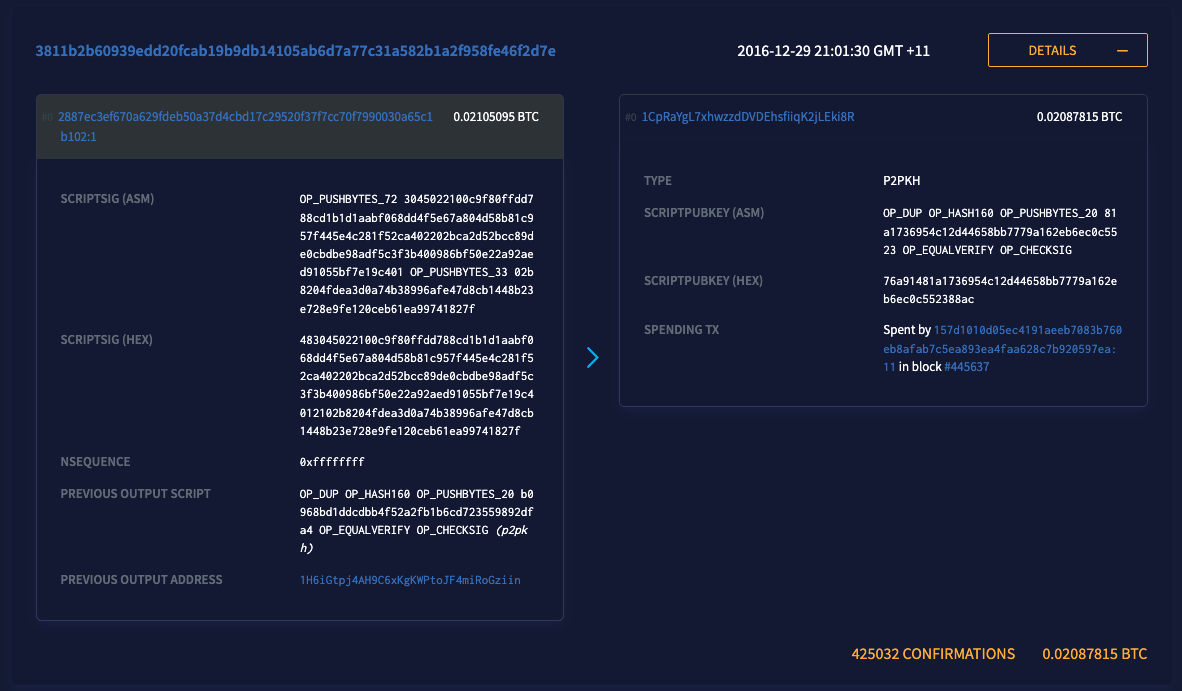

In [ ]:
df_addraddr[df_addraddr['input_address']=='1H6iGtpj4AH9C6xKgKWPtoJF4miRoGziin']

,input_address,output_address
874938,1H6iGtpj4AH9C6xKgKWPtoJF4miRoGziin,1CpRaYgL7xhwzzdDVDEhsfiiqK2jLEki8R


In [ ]:
df_addrtxn_edgelist[df_addrtxn_edgelist['input_address']=='1H6iGtpj4AH9C6xKgKWPtoJF4miRoGziin']

,input_address,txId
263829,1H6iGtpj4AH9C6xKgKWPtoJF4miRoGziin,139232043


In [ ]:
df_txn_features[df_txn_features['txId']==139232043]

,txId,Time step,in_txs_degree,out_txs_degree,total_BTC,fees,size,num_input_addresses,num_output_addresses,in_BTC_min,in_BTC_max,in_BTC_mean,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total
20714,139232043,28,0.0000,1.0000,0.0209,0.0002,192.0000,1.0000,1.0000,0.0211,0.0211,0.0211,0.0211,0.0211,0.0209,0.0209,0.0209,0.0209,0.0209


-----------------------

Illicit Address Validation #2: 1DzPbE2QET1WmdiFywGyxzSNWWBC7jAuSz

Notes:
- Input address, output address and BTC txn value are validated using BTC Scan https://btcscan.org/address/1DzPbE2QET1WmdiFywGyxzSNWWBC7jAuSz
- No illicit reports on https://www.chainabuse.com/
- No illicit reports on https://tools.cybertrace.com.au/

-----------------------

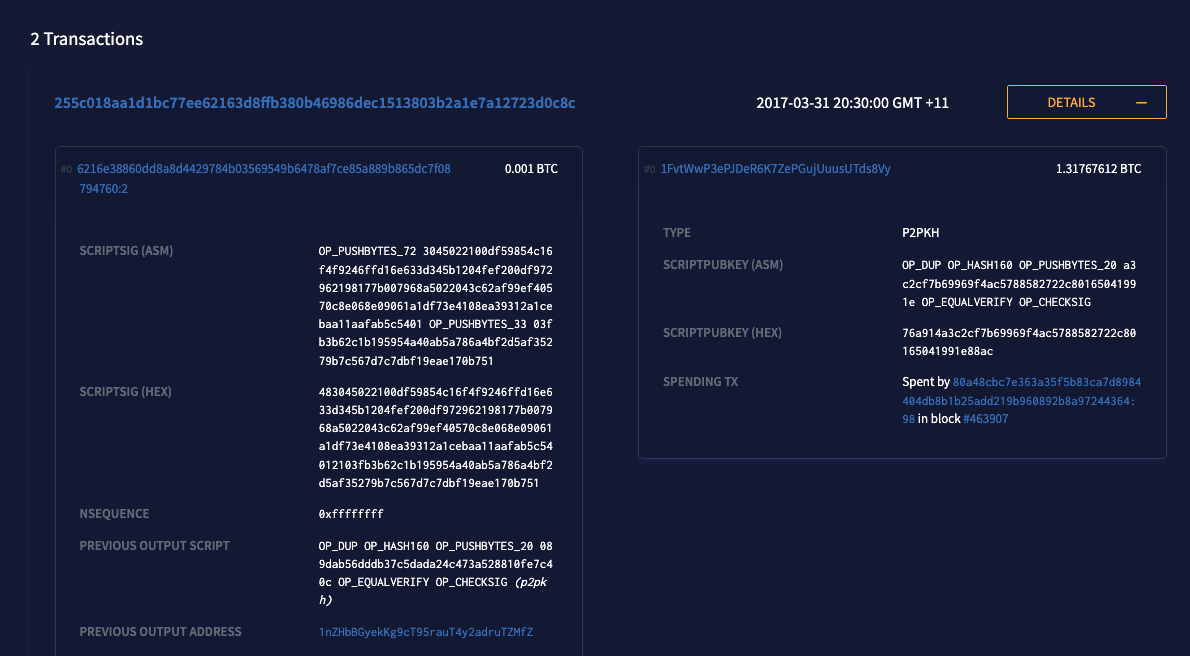

In [ ]:
df_addraddr[df_addraddr['input_address']=='1DzPbE2QET1WmdiFywGyxzSNWWBC7jAuSz']

,input_address,output_address
1218871,1DzPbE2QET1WmdiFywGyxzSNWWBC7jAuSz,1FvtWwP3ePJDeR6K7ZePGujUuusUTds8Vy


In [ ]:
df_addrtxn_edgelist[df_addrtxn_edgelist['input_address']=='1DzPbE2QET1WmdiFywGyxzSNWWBC7jAuSz']

,input_address,txId
320236,1DzPbE2QET1WmdiFywGyxzSNWWBC7jAuSz,70023047


In [ ]:
df_txn_features[df_txn_features['txId']==70023047]

,txId,Time step,in_txs_degree,out_txs_degree,total_BTC,fees,size,num_input_addresses,num_output_addresses,in_BTC_min,in_BTC_max,in_BTC_mean,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total
84625,70023047,35,48.0000,0.0000,1.3177,0.0388,27483.0000,186.0000,1.0000,0.0008,0.1423,0.0073,0.0029,1.3565,1.3177,1.3177,1.3177,1.3177,1.3177


-----------------------

Illicit Address Validation #3: 1EsMBSwcw94uCmph4bTshs6o8THZQn3QFZ

Notes:
- Input address, output address and BTC txn value are validated using BTC Scan https://btcscan.org/address/1EsMBSwcw94uCmph4bTshs6o8THZQn3QFZ
- No illicit reports on https://www.chainabuse.com/
- No illicit reports on https://tools.cybertrace.com.au/

-----------------------


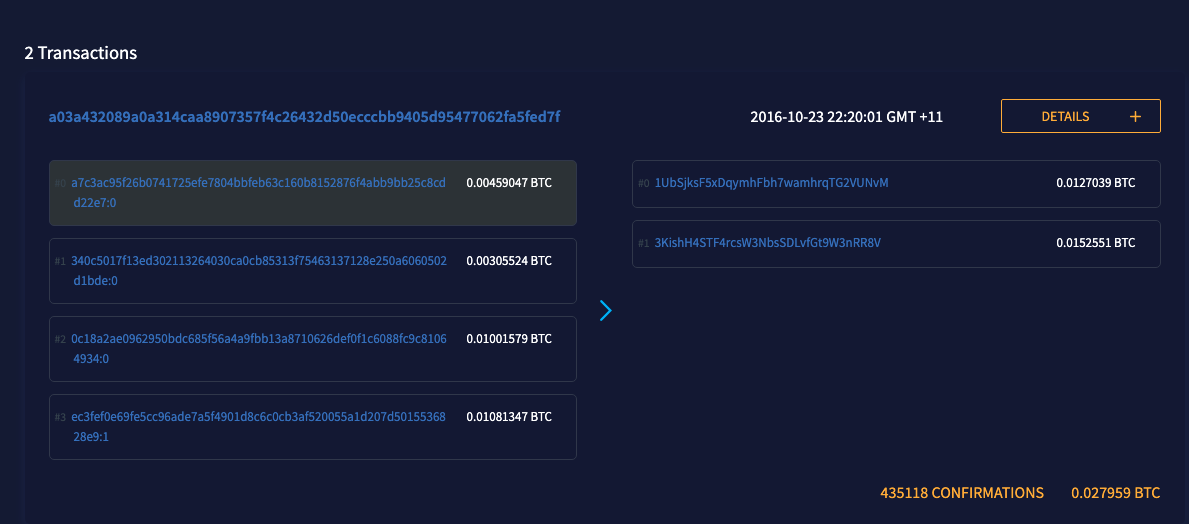

In [ ]:
df_addraddr[df_addraddr['input_address']=='1EsMBSwcw94uCmph4bTshs6o8THZQn3QFZ']

,input_address,output_address
2047917,1EsMBSwcw94uCmph4bTshs6o8THZQn3QFZ,1UbSjksF5xDqymhFbh7wamhrqTG2VUNvM
2405089,1EsMBSwcw94uCmph4bTshs6o8THZQn3QFZ,3KishH4STF4rcsW3NbsSDLvfGt9W3nRR8V


In [ ]:
df_addrtxn_edgelist[df_addrtxn_edgelist['input_address']=='1EsMBSwcw94uCmph4bTshs6o8THZQn3QFZ']

,input_address,txId
232045,1EsMBSwcw94uCmph4bTshs6o8THZQn3QFZ,331501576


In [ ]:
df_txn_features[df_txn_features['txId']==331501576]

,txId,Time step,in_txs_degree,out_txs_degree,total_BTC,fees,size,num_input_addresses,num_output_addresses,in_BTC_min,in_BTC_max,in_BTC_mean,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total
188027,331501576,23,0.0000,1.0000,0.0280,0.0005,666.0000,4.0000,2.0000,0.0031,0.0108,0.0071,0.0073,0.0285,0.0127,0.0153,0.0140,0.0140,0.0280


-----------------------

Illicit Address Validation #4: 1CXu6V1gdEqQcd3A6E1aLDqrdzJUSZTVwK

Notes:
- Input address, output address and BTC txn value are validated using BTC Scan https://btcscan.org/address/1CXu6V1gdEqQcd3A6E1aLDqrdzJUSZTVwK
- No illicit reports on https://www.chainabuse.com/
- No illicit reports on https://tools.cybertrace.com.au/

-----------------------


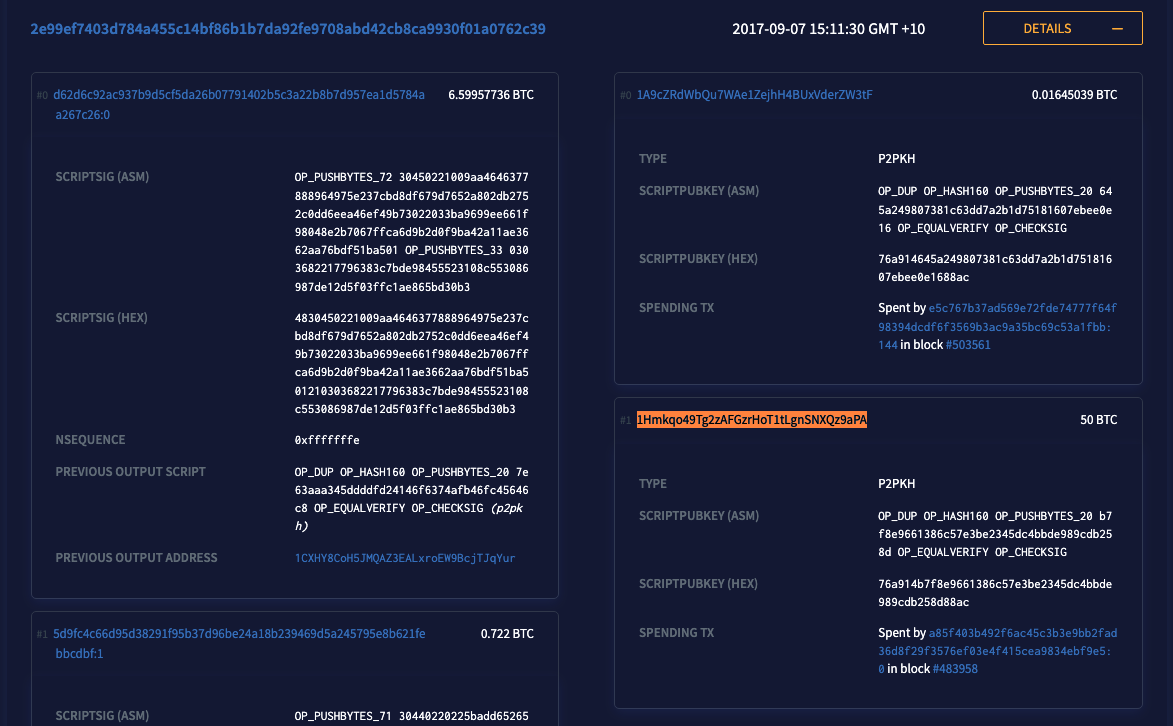

In [ ]:
df_addraddr[df_addraddr['input_address']=='1CXu6V1gdEqQcd3A6E1aLDqrdzJUSZTVwK']

,input_address,output_address
2782540,1CXu6V1gdEqQcd3A6E1aLDqrdzJUSZTVwK,1Hmkqo49Tg2zAFGzrHoT1tLgnSNXQz9aPA
2802915,1CXu6V1gdEqQcd3A6E1aLDqrdzJUSZTVwK,1A9cZRdWbQu7WAe1ZejhH4BUxVderZW3tF


In [ ]:
df_addrtxn_edgelist[df_addrtxn_edgelist['input_address']=='1CXu6V1gdEqQcd3A6E1aLDqrdzJUSZTVwK']

,input_address,txId
461192,1CXu6V1gdEqQcd3A6E1aLDqrdzJUSZTVwK,212722108


In [ ]:
df_txn_features[df_txn_features['txId']==	212722108]

,txId,Time step,in_txs_degree,out_txs_degree,total_BTC,fees,size,num_input_addresses,num_output_addresses,in_BTC_min,in_BTC_max,in_BTC_mean,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total
68554,212722108,47,8.0000,0.0000,50.0165,0.0076,3766.0000,25.0000,2.0000,0.0000,6.5996,2.0010,1.8360,50.0240,0.0165,50.0000,25.0082,25.0082,50.0165


-----------------------

Illicit Address Validation #5: 1H2oqGARVmLUE76reV4ZdPnaVR1MHTyc6V

Notes:
- Input address, output address and BTC txn value are validated using BTC Scan https://btcscan.org/address/1H2oqGARVmLUE76reV4ZdPnaVR1MHTyc6V
- No illicit reports on https://www.chainabuse.com/
- No illicit reports on https://tools.cybertrace.com.au/

-----------------------


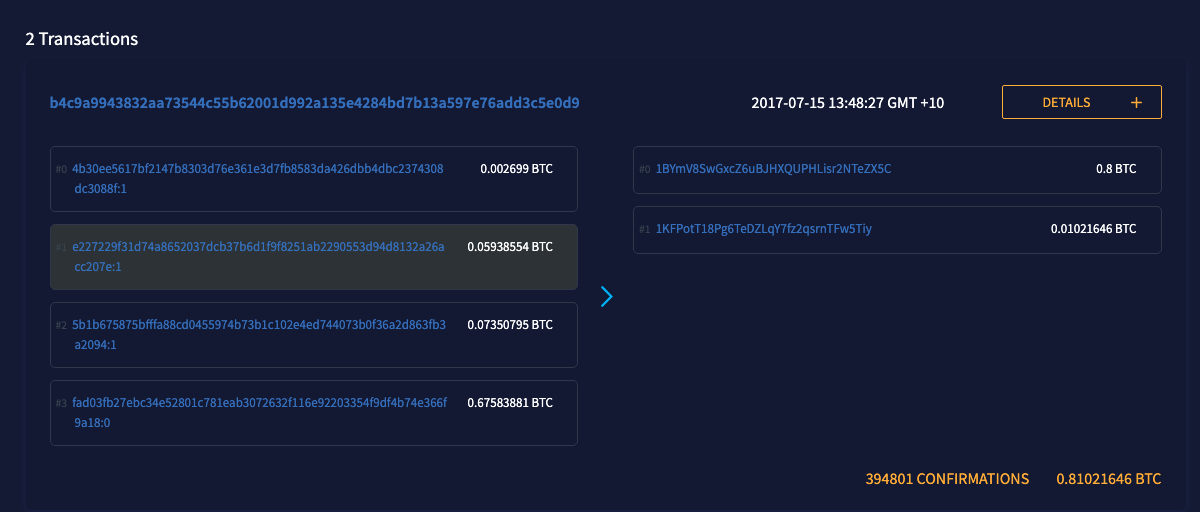

In [ ]:
df_addraddr[df_addraddr['input_address']=='1H2oqGARVmLUE76reV4ZdPnaVR1MHTyc6V']

,input_address,output_address
1918455,1H2oqGARVmLUE76reV4ZdPnaVR1MHTyc6V,1KFPotT18Pg6TeDZLqY7fz2qsrnTFw5Tiy
1999798,1H2oqGARVmLUE76reV4ZdPnaVR1MHTyc6V,1BYmV8SwGxcZ6uBJHXQUPHLisr2NTeZX5C


In [ ]:
df_addrtxn_edgelist[df_addrtxn_edgelist['input_address']=='1H2oqGARVmLUE76reV4ZdPnaVR1MHTyc6V']

,input_address,txId
405925,1H2oqGARVmLUE76reV4ZdPnaVR1MHTyc6V,94151590


In [ ]:
df_txn_features[df_txn_features['txId']==	94151590]

,txId,Time step,in_txs_degree,out_txs_degree,total_BTC,fees,size,num_input_addresses,num_output_addresses,in_BTC_min,in_BTC_max,in_BTC_mean,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total
83146,94151590,43,0.0000,1.0000,0.8102,0.0012,668.0000,4.0000,2.0000,0.0027,0.6758,0.2029,0.0664,0.8114,0.0102,0.8000,0.4051,0.4051,0.8102


-----------------------

Illicit Address Validation #6: 1D1SLGb19PASxR3dCY7qXLVFnsDsnJu4GL

Notes:
- Input address, output address and BTC txn value are validated using BTC Scan https://btcscan.org/address/1D1SLGb19PASxR3dCY7qXLVFnsDsnJu4GL
- No illicit reports on https://www.chainabuse.com/
- No illicit reports on https://tools.cybertrace.com.au/

-----------------------


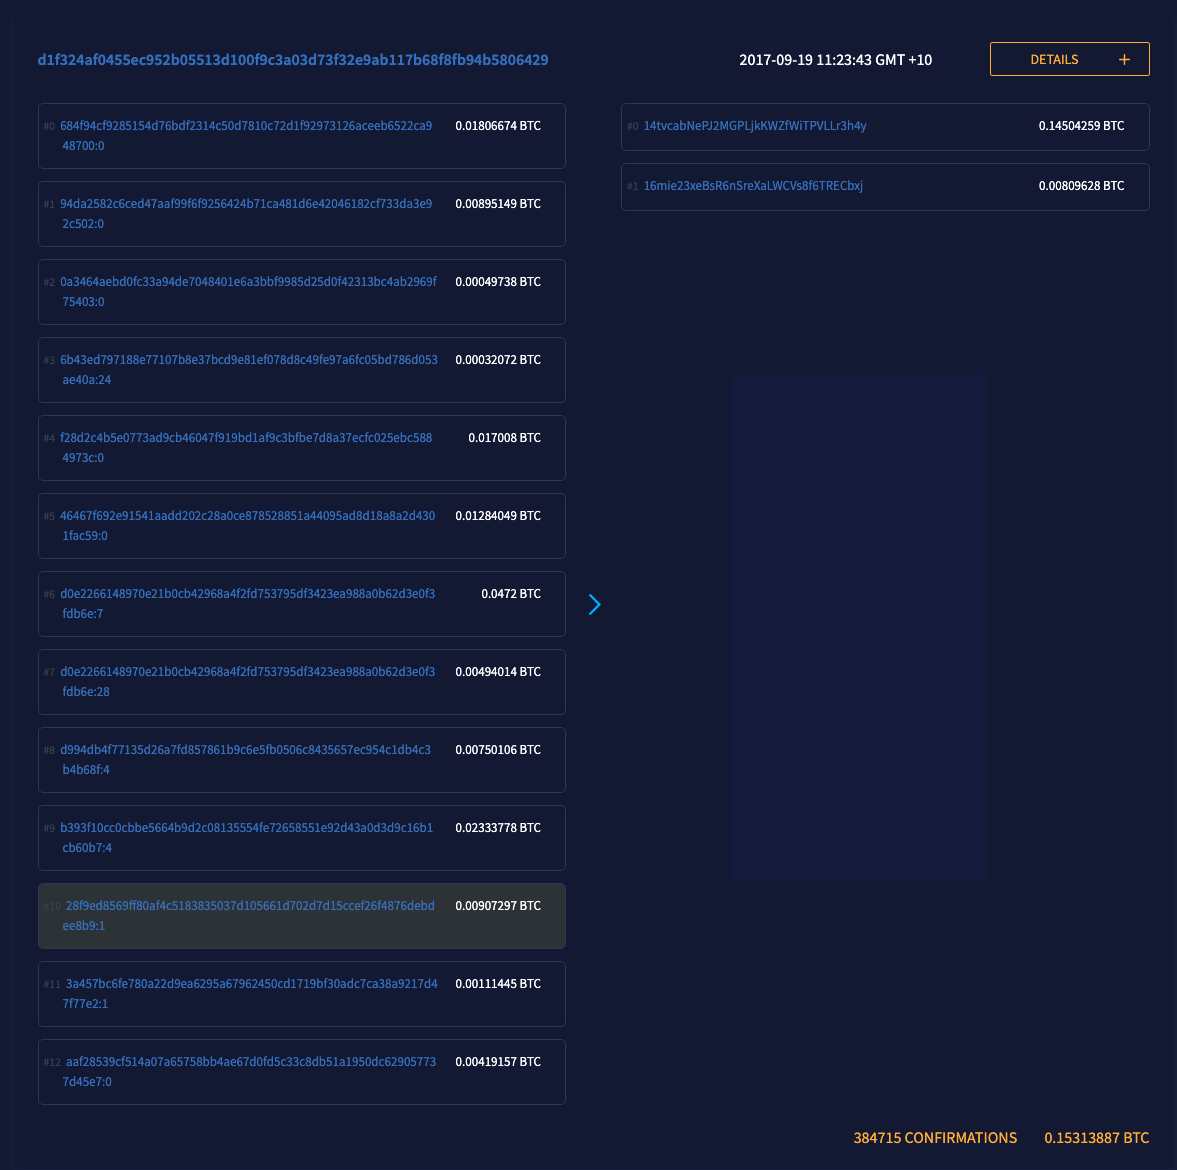

In [ ]:
df_addraddr[df_addraddr['input_address']=='1D1SLGb19PASxR3dCY7qXLVFnsDsnJu4GL']

,input_address,output_address
2752634,1D1SLGb19PASxR3dCY7qXLVFnsDsnJu4GL,16mie23xeBsR6nSreXaLWCVs8f6TRECbxj
2798478,1D1SLGb19PASxR3dCY7qXLVFnsDsnJu4GL,14tvcabNePJ2MGPLjkKWZfWiTPVLLr3h4y


In [ ]:
df_addrtxn_edgelist[df_addrtxn_edgelist['input_address']=='1D1SLGb19PASxR3dCY7qXLVFnsDsnJu4GL']

,input_address,txId
468999,1D1SLGb19PASxR3dCY7qXLVFnsDsnJu4GL,19501341


In [ ]:
df_txn_features[df_txn_features['txId']==	19501341]

,txId,Time step,in_txs_degree,out_txs_degree,total_BTC,fees,size,num_input_addresses,num_output_addresses,in_BTC_min,in_BTC_max,in_BTC_mean,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total
44333,19501341,48,0.0000,1.0000,0.1531,0.0019,1994.0000,13.0000,2.0000,0.0003,0.0472,0.0119,0.0090,0.1550,0.0081,0.1450,0.0766,0.0766,0.1531


-----------------------

Illicit Address Validation #7: 1BmwhwBzyeuNoZirB6hmeDEqztUZTyJ8qC

Notes:
- Input address, output address and BTC txn value are validated using BTC Scan https://btcscan.org/address/1BmwhwBzyeuNoZirB6hmeDEqztUZTyJ8qC
- No illicit reports on https://www.chainabuse.com/
- No illicit reports on https://tools.cybertrace.com.au/

-----------------------


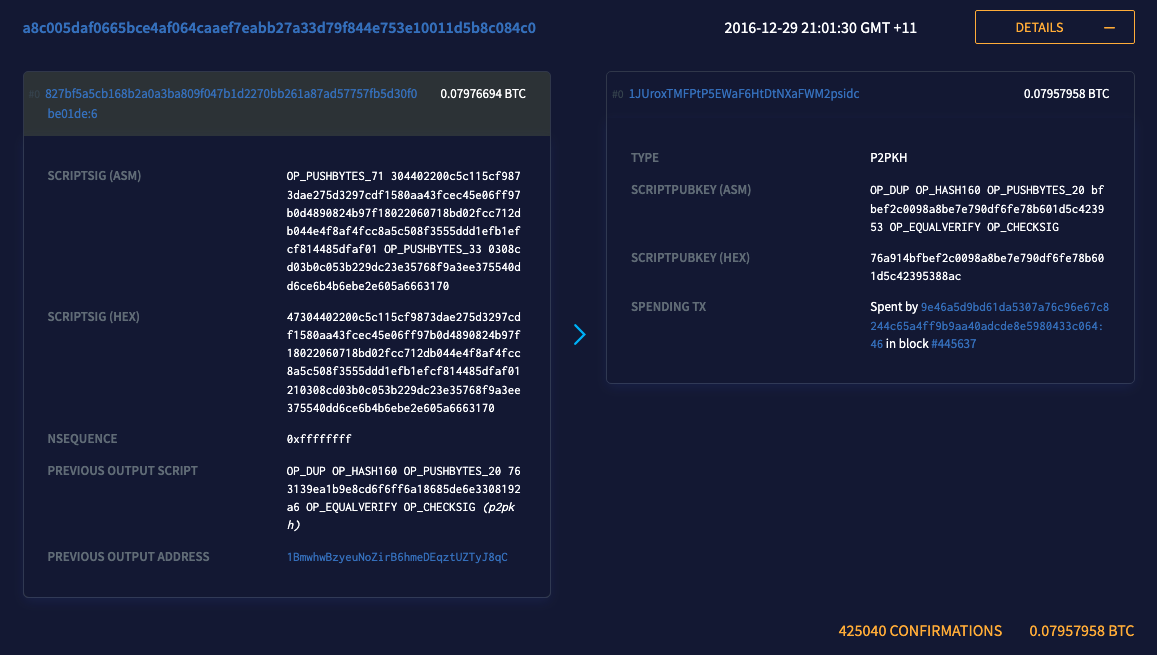

In [ ]:
df_addraddr[df_addraddr['input_address']=='1BmwhwBzyeuNoZirB6hmeDEqztUZTyJ8qC']

,input_address,output_address
407862,1BmwhwBzyeuNoZirB6hmeDEqztUZTyJ8qC,1JUroxTMFPtP5EWaF6HtDtNXaFWM2psidc


In [ ]:
df_addrtxn_edgelist[df_addrtxn_edgelist['input_address']=='1BmwhwBzyeuNoZirB6hmeDEqztUZTyJ8qC']

,input_address,txId
263764,1BmwhwBzyeuNoZirB6hmeDEqztUZTyJ8qC,139274519


In [ ]:
df_txn_features[df_txn_features['txId']==	139274519]

,txId,Time step,in_txs_degree,out_txs_degree,total_BTC,fees,size,num_input_addresses,num_output_addresses,in_BTC_min,in_BTC_max,in_BTC_mean,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total
80696,139274519,28,0.0000,1.0000,0.0796,0.0002,191.0000,1.0000,1.0000,0.0798,0.0798,0.0798,0.0798,0.0798,0.0796,0.0796,0.0796,0.0796,0.0796


-----------------------

Illicit Address Validation #8: 1GxNcfosQouiwjtui1kALEN61zR5DqXNhS

Notes:
- Input address, output address and BTC txn value are validated using BTC Scan https://btcscan.org/address/1GxNcfosQouiwjtui1kALEN61zR5DqXNhS
- No illicit reports on https://www.chainabuse.com/
- No illicit reports on https://tools.cybertrace.com.au/

-----------------------


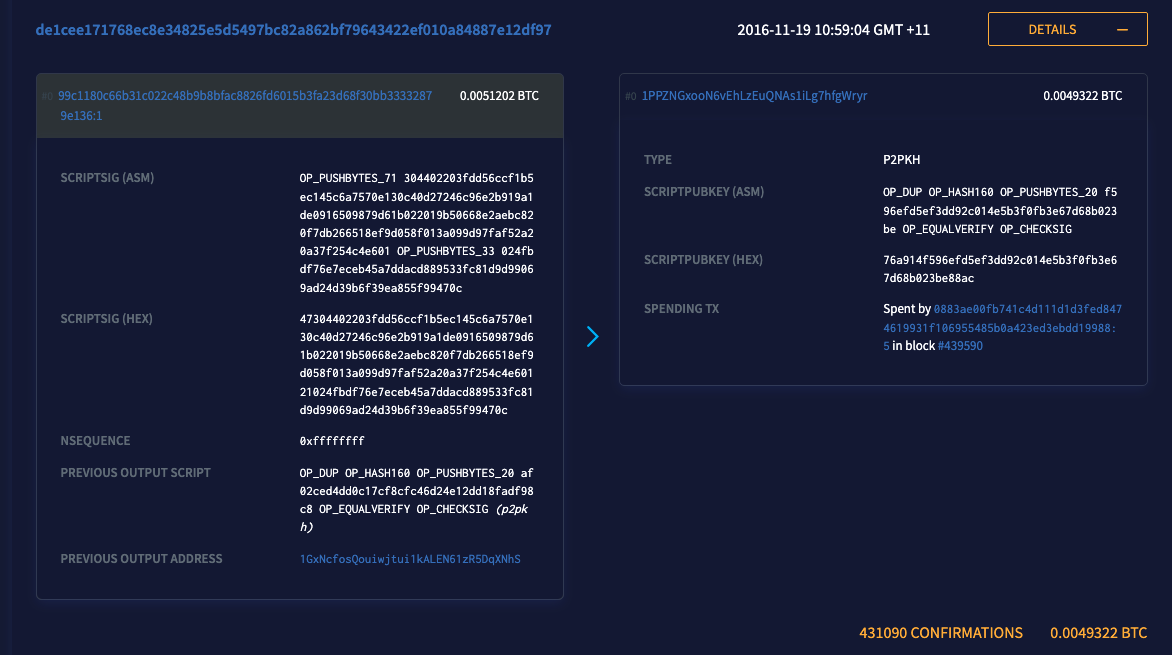

In [ ]:
df_addraddr[df_addraddr['input_address']=='1GxNcfosQouiwjtui1kALEN61zR5DqXNhS']

,input_address,output_address
2103407,1GxNcfosQouiwjtui1kALEN61zR5DqXNhS,1PPZNGxooN6vEhLzEuQNAs1iLg7hfgWryr


In [ ]:
df_addrtxn_edgelist[df_addrtxn_edgelist['input_address']=='1GxNcfosQouiwjtui1kALEN61zR5DqXNhS']

,input_address,txId
248183,1GxNcfosQouiwjtui1kALEN61zR5DqXNhS,268791658


In [ ]:
df_txn_features[df_txn_features['txId']==		268791658]

,txId,Time step,in_txs_degree,out_txs_degree,total_BTC,fees,size,num_input_addresses,num_output_addresses,in_BTC_min,in_BTC_max,in_BTC_mean,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total
77833,268791658,25,0.0000,1.0000,0.0049,0.0002,191.0000,1.0000,1.0000,0.0051,0.0051,0.0051,0.0051,0.0051,0.0049,0.0049,0.0049,0.0049,0.0049


-----------------------

Illicit Address Validation #9: 1Ea6fUL4SetTurKScVjPrrtQkY6bXoSjEx

Notes:
- Input address, output address and BTC txn value are validated using BTC Scan https://btcscan.org/address/1Ea6fUL4SetTurKScVjPrrtQkY6bXoSjEx
- No illicit reports on https://www.chainabuse.com/
- No illicit reports on https://tools.cybertrace.com.au/

-----------------------


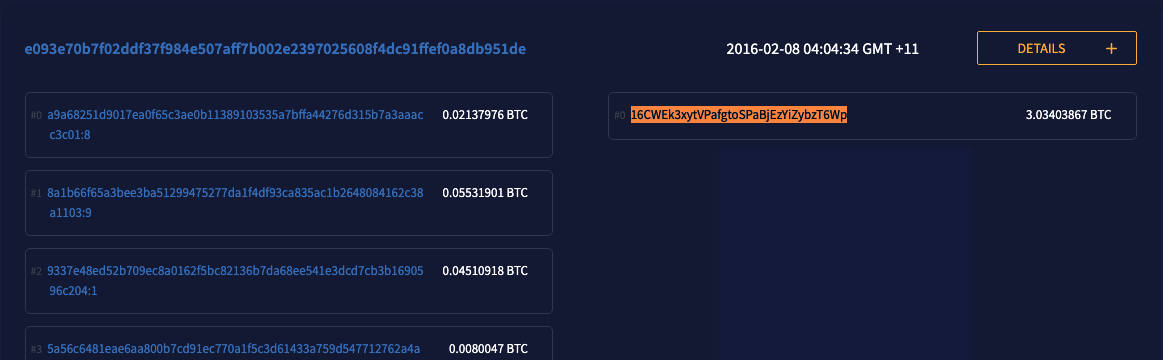

In [ ]:
df_addraddr[df_addraddr['input_address']=='1Ea6fUL4SetTurKScVjPrrtQkY6bXoSjEx']

,input_address,output_address
238810,1Ea6fUL4SetTurKScVjPrrtQkY6bXoSjEx,16CWEk3xytVPafgtoSPaBjEzYiZybzT6Wp


In [ ]:
df_addrtxn_edgelist[df_addrtxn_edgelist['input_address']=='1Ea6fUL4SetTurKScVjPrrtQkY6bXoSjEx']

,input_address,txId
46492,1Ea6fUL4SetTurKScVjPrrtQkY6bXoSjEx,279470784


In [ ]:
df_txn_features[df_txn_features['txId']==279470784]

,txId,Time step,in_txs_degree,out_txs_degree,total_BTC,fees,size,num_input_addresses,num_output_addresses,in_BTC_min,in_BTC_max,in_BTC_mean,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total
83379,279470784,4,0.0000,1.0000,3.0340,0.0034,14792.0000,100.0000,1.0000,0.0013,0.4884,0.0304,0.0226,3.0375,3.0340,3.0340,3.0340,3.0340,3.0340


-----------------------

Illicit Address Validation #10: 17mvMgJUms7xp51ch6B2N6WbfwFkJH6FN

Notes:
- Input address, output address and BTC txn value are validated using BTC Scan https://btcscan.org/address/17mvMgJUms7xp51ch6B2N6WbfwFkJH6FN
- This is the same transaction as Example #9. This input address is one of 100 input addresses in the same transaction.
- No illicit reports on https://www.chainabuse.com/
- No illicit reports on https://tools.cybertrace.com.au/

-----------------------


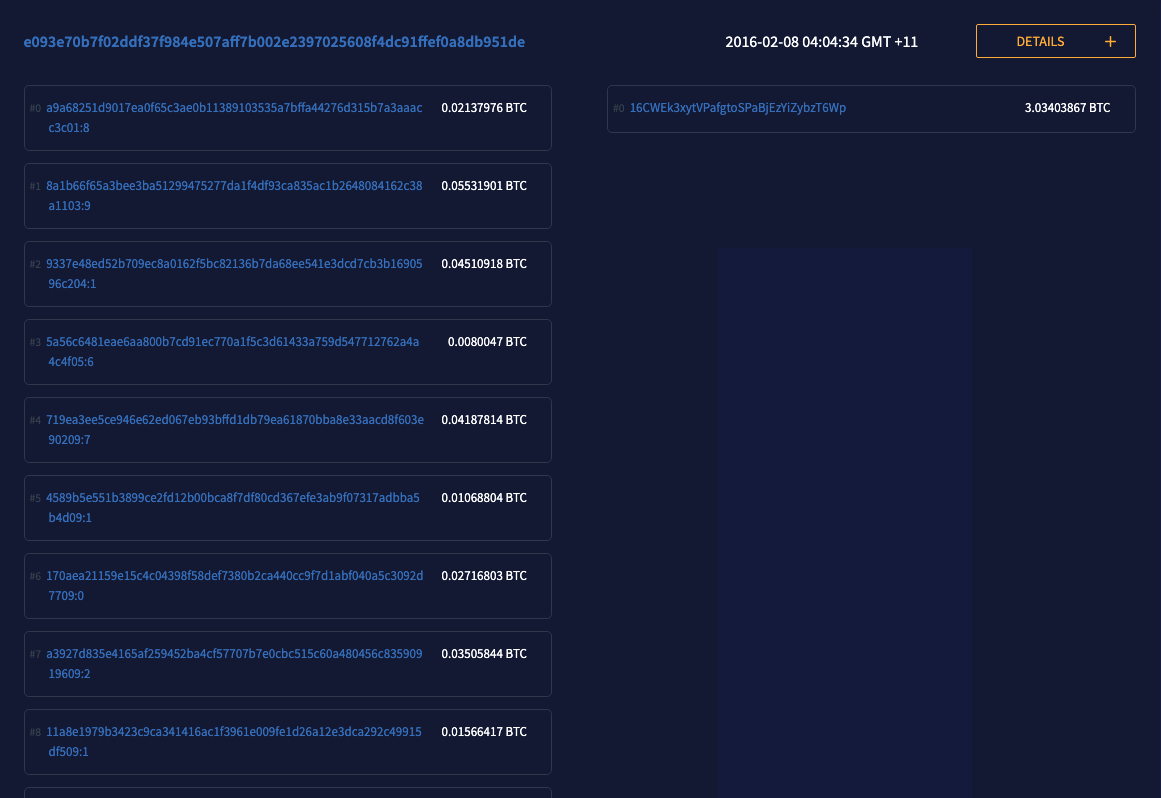

In [ ]:
df_addraddr[df_addraddr['input_address']=='17mvMgJUms7xp51ch6B2N6WbfwFkJH6FN']

,input_address,output_address
398195,17mvMgJUms7xp51ch6B2N6WbfwFkJH6FN,16CWEk3xytVPafgtoSPaBjEzYiZybzT6Wp


In [ ]:
df_addrtxn_edgelist[df_addrtxn_edgelist['input_address']=='17mvMgJUms7xp51ch6B2N6WbfwFkJH6FN']

,input_address,txId
46483,17mvMgJUms7xp51ch6B2N6WbfwFkJH6FN,279470784


In [ ]:
df_txn_features[df_txn_features['txId']==279470784]

,txId,Time step,in_txs_degree,out_txs_degree,total_BTC,fees,size,num_input_addresses,num_output_addresses,in_BTC_min,in_BTC_max,in_BTC_mean,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total
83379,279470784,4,0.0000,1.0000,3.0340,0.0034,14792.0000,100.0000,1.0000,0.0013,0.4884,0.0304,0.0226,3.0375,3.0340,3.0340,3.0340,3.0340,3.0340


----------------------

Illicit Samples where the volume of transactions is high.

The reason for selecting addresses with high transaction volume is so we can validate whether the address is licit or illicit using public address lookup / AML websites.

Note:
- Using free wallet address lookups (chainabuse.com and cybertrace.com.au) there have been no illicit activity noted.
- There are many other AML crypto wallet lookup serves (e.g. Elliptic) but they are paid services.

----------------------

In [ ]:
illicit_address = df_wallet_combined_clean[(df_wallet_combined_clean['class_label']=='Illicit')].sort_values(ascending = False, by = 'total_txs').head(10)
illicit_address

,address,class,class_label,num_txs_as_sender,num_txs_as receiver,first_block_appeared_in,last_block_appeared_in,lifetime_in_blocks,total_txs,first_sent_block,first_received_block,num_timesteps_appeared_in,btc_transacted_total,btc_transacted_min,btc_transacted_max,btc_transacted_mean,btc_transacted_median,btc_sent_total,btc_sent_min,btc_sent_max,btc_sent_mean,btc_sent_median,btc_received_total,btc_received_min,btc_received_max,btc_received_mean,btc_received_median,fees_total,fees_min,fees_max,fees_mean,fees_median,fees_as_share_total,fees_as_share_min,fees_as_share_max,fees_as_share_mean,fees_as_share_median,blocks_btwn_txs_total,blocks_btwn_txs_min,blocks_btwn_txs_max,blocks_btwn_txs_mean,blocks_btwn_txs_median,blocks_btwn_input_txs_total,blocks_btwn_input_txs_min,blocks_btwn_input_txs_max,blocks_btwn_input_txs_mean,blocks_btwn_input_txs_median,blocks_btwn_output_txs_total,blocks_btwn_output_txs_min,blocks_btwn_output_txs_max,blocks_btwn_output_txs_mean,blocks_btwn_output_txs_median,num_addr_transacted_multiple,transacted_w_address_total,transacted_w_address_min,transacted_w_address_max,transacted_w_address_mean,transacted_w_address_median
599684,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,1,Illicit,420.0000,1.0000,435559.0000,453704.0000,18145.0000,421.0000,435559.0000,451682.0000,6.0000,27.4758,0.0006,20.0000,0.0653,0.0041,7.4758,0.0000,0.5004,0.0178,0.0041,20.0000,0.0000,20.0000,0.0475,0.0000,0.1884,0.0003,0.0248,0.0004,0.0004,0.1857,0.0003,0.0221,0.0004,0.0004,18145.0000,0.0000,6044.0000,43.2024,0.0000,18145.0000,0.0000,6044.0000,43.3055,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,17.0000,495.0000,1.0000,3.0000,1.0465,1.0000
547087,1DYyueWpZriK9mdCKqUPiTKg3vaHYaPdCK,1,Illicit,5.0000,89.0000,415393.0000,415397.0000,4.0000,94.0000,415395.0000,415393.0000,1.0000,55.9634,0.0015,16.2218,0.5954,0.1705,27.9817,0.0000,16.2218,0.2977,0.0000,27.9817,0.0000,1.6743,0.2977,0.1521,0.0308,0.0002,0.0040,0.0003,0.0002,0.0199,0.0000,0.0013,0.0002,0.0002,4.0000,0.0000,2.0000,0.0430,0.0000,2.0000,0.0000,1.0000,0.5000,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,99.0000,1.0000,4.0000,1.0879,1.0000
245916,13PTX5TUaGvPPZ5j1ushpDzeFqwVCzkwXg,1,Illicit,1.0000,92.0000,453697.0000,453705.0000,8.0000,93.0000,453705.0000,453697.0000,1.0000,26.9458,0.0007,13.4729,0.2897,0.0556,13.4729,0.0000,13.4729,0.1449,0.0000,13.4729,0.0000,2.1998,0.1449,0.0522,0.0437,0.0002,0.0171,0.0005,0.0003,0.0335,0.0002,0.0075,0.0004,0.0003,8.0000,0.0000,5.0000,0.0870,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,0.0000,1.0000,0.0330,0.0000,4.0000,94.0000,1.0000,2.0000,1.0444,1.0000
492293,1GQSnzh9JRgipxC7btKvD3rBS8Zj8SVnAo,1,Illicit,35.0000,33.0000,437582.0000,477896.0000,40314.0000,68.0000,453703.0000,437582.0000,15.0000,9.7612,0.0005,1.9995,0.1435,0.0493,4.4519,0.0000,1.9995,0.0655,0.0007,5.3093,0.0000,1.9995,0.0781,0.0000,0.2030,0.0004,0.0360,0.0030,0.0009,0.0425,0.0002,0.0010,0.0006,0.0006,40326.0000,0.0000,8056.0000,601.8806,1.0000,24205.0000,0.0000,10076.0000,711.9118,1.0000,40323.0000,0.0000,8056.0000,1260.0938,4.5000,1.0000,103.0000,1.0000,2.0000,1.0098,1.0000
635666,1HF1yyeF8TNRnUuSES94KduL1pXg2wKmT8,1,Illicit,1.0000,64.0000,447651.0000,447652.0000,1.0000,65.0000,447652.0000,447651.0000,1.0000,24.5406,0.0026,12.2703,0.3775,0.0977,12.2703,0.0000,12.2703,0.1888,0.0000,12.2703,0.0000,1.4800,0.1888,0.0787,0.0318,0.0002,0.0136,0.0005,0.0003,0.0316,0.0002,0.0136,0.0005,0.0003,1.0000,0.0000,1.0000,0.0156,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,65.0000,1.0000,1.0000,1.0000,1.0000
678408,1H9xYMZv9Ya3SU58in3PnydtnJm8cPHRi9,1,Illicit,1.0000,63.0000,415396.0000,415397.0000,1.0000,64.0000,415397.0000,415396.0000,1.0000,39.9718,0.0075,19.9859,0.6246,0.1617,19.9859,0.0000,19.9859,0.3123,0.0000,19.9859,0.0000,4.4968,0.3123,0.1504,0.0197,0.0002,0.0071,0.0003,0.0002,0.0195,0.0001,0.0071,0.0003,0.0002,1.0000,0.0000,1.0000,0.0159,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,64.0000,1.0000,1.0000,1.0000,1.000

End of Validation